In [30]:
# from sklearn.datasets import load_iris
# iris = load_iris(as_frame=True)
# # Access data as DataFrame
# data_df = iris.data # petal length and width
# iris_df = data_df.iloc[:,2:]
# iris_df.head()
# # Access target as Series or DataFrame (depending on the number of target columns)
# target_series = iris.target
# target_series


0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int64

In [42]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier , export_graphviz

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
Y = iris.target
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [43]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X,Y)

DecisionTreeClassifier(max_depth=2)

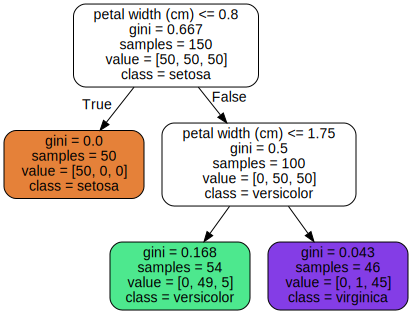

In [59]:
from graphviz import Source
import os

IMAGES_PATH = os.path.join("images/classification/")
export_graphviz(tree_clf,out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),feature_names=iris.feature_names[2:],class_names=iris.target_names,rounded=True,filled=True)
Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

In [68]:
tree_clf.predict_proba([[5,1.5]]) #array([[0.        , 0.90740741, 0.09259259]])
tree_clf.predict([[5,1.5]]) #array([1]) indicates index 1

array([1])

---
---

## EXERCISE

7.

In [5]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split , GridSearchCV
X , y = make_moons(n_samples=10000, noise=0.4)
x_train , x_test , y_train , y_test = train_test_split(X,y,test_size=0.25,random_state=42)
# print(x_train)
# print(y_train)


In [6]:
from sklearn.tree import DecisionTreeClassifier

"""(*, criterion: Literal['gini', 'entropy', 'log_loss'] = "gini", splitter: Literal['best', 'random'] = "best", max_depth: Int | None = None, min_samples_split: float | int = 2, min_samples_leaf: float | int = 1, min_weight_fraction_leaf: Float = 0, max_features: float | int | Literal['auto', 'sqrt', 'log2'] | None = None, random_state: Int | RandomState | None = None, max_leaf_nodes: Int | None = None, min_impurity_decrease: Float = 0, class_weight: Mapping | str | Sequence[Mapping] | None = None, ccp_alpha: float = 0) -> None"""


tree_params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),tree_params,verbose=1,cv=3)
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [10]:
grid_search.best_params_
final_model_tree = grid_search.best_estimator_

In [11]:
final_model_tree.fit(x_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=14, random_state=42)

In [12]:
y_preds = final_model_tree.predict(x_test)

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_preds)

0.8592

8.

In [20]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(x_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(x_train):
    X_mini_train = x_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [21]:
from sklearn.base import clone
import numpy as np
forest = [clone(grid_search.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(x_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)


0.8040364

In [22]:
Y_pred = np.empty([n_trees, len(x_test)], dtype=np.uint8)
for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(x_test)

In [23]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [24]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.8588